# Statistical Analysis

## Overview
My goal in this analysis was to build upon my [initial EDA](https://github.com/lucasmybrotha/Predict-Ratings-for-Drug-Reviews/blob/master/drugsCom_DataStorytelling.ipynb) with more in depth analysis of features. I evaluated statistically significant correlations and average differences in rating for the following features.
- Review length
- Drug name
- Condition
- Review text

Columns and column descriptions for the 'data' dataframe are listed below. The 'term_matrix' dataframe is a document-term matrix with a column for each word, row for each review, and word frequency counts as values.

| Column Name | Description |
| :--- | :--- |
| userID | Anonymous user ID |
| drugName | Name of drug reviewed |
| condition | Condition drug was used for |
| review | Review text |
| rating | Rating from 1 to 10 |
| date | Date of review |
| usefulCount | Number of times voted as useful by viewers |
| character_count | Number of characters in review text |
| word_count | Number of words in review text |
| clean_review | Review text cleaned and pre-processed |

## Import
I imported libraries that will be used along with data from previous steps.

In [15]:
# import libraries
import numpy as np
import pandas as pd

from scipy import stats
from scipy.sparse import load_npz
import pickle

# visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

In [16]:
# import dataset
data = pd.read_pickle('drugsCom_data')

In [264]:
data.head()

,userID,drugName,condition,review,rating,date,usefulCount,character_count,word_count,clean_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,79,17,combination bystolic mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,741,141,son halfway fourth intuniv became concerned be...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,755,133,used another oral contraceptive pill cycle hap...
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10,448,89,first using form birth control glad went patch...
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37,719,134,suboxone completely turned life around feel he...


In [17]:
# import sparse matrix
from scipy.sparse import load_npz

term_matrix = load_npz('ngram_csr.npz')

# convert back to dataframe
term_matrix = pd.DataFrame(term_matrix.todense())

In [18]:
# import column headers for dataframe
import pickle

pickle_in = open('list.pickle', 'rb')
reviews_columns = pickle.load(pickle_in)

# add column headers back to dataframe
term_matrix.columns = reviews_columns

In [19]:
# add ratings back to the matrix to allow filtering
term_matrix['rating'] = data['rating']

In [20]:
term_matrix = term_matrix.dropna()

In [21]:
data.head(3)

,userID,drugName,condition,review,rating,date,usefulCount,character_count,word_count,clean_review
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27,79,17,combination bystolic mg fish oil
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192,741,141,son halfway fourth intuniv became concerned be...
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17,755,133,used another oral contraceptive pill cycle hap...


## Rating by Review Length

### Visualization
I used box plots to see if there a relationship between review length and rating could be seen. I chose to use both character count and word count calculated prior to cleaning and preprocessing the text.

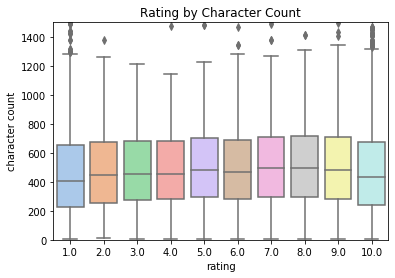

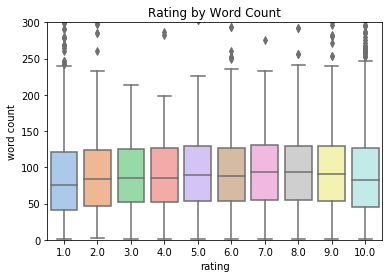

In [22]:
sns.set_palette('pastel')

# boxplot of character count vs. rating
_ = sns.boxplot(x='rating', y='character_count', data=data)
_ = plt.title('Rating by Character Count')
_ = plt.xlabel('rating')
_ = plt.ylabel('character count')
_ = plt.ylim(0,1500)
plt.show()

# boxplot of word count vs. rating
_ = sns.boxplot(x='rating', y='word_count', data=data)
_ = plt.title('Rating by Word Count')
_ = plt.xlabel('rating')
_ = plt.ylabel('word count')
_ = plt.ylim(0,300)
plt.show()

### Significant Correlation
There wasn't a clear relationship between review length and rating in the boxplots, so I wanted to take a more quantitative approach.

My null hypothesis was that there was not a correlation (i.e. correlation coefficient was zero). My alternative hypothesis was that there was a correlation (i.e. correlation coefficient was not zero).

An alpha (p-value) of 0.05 was used to determine statistical significance.

#### Word Count

With a p-value less than our alpha of 0.05, word count did have a statistically significant correlation with rating, but the correlation was very weak. The correlation coefficient was about 0.027.

In [62]:
# calculate perason correlation coefficient and p-value
corr_coeff, p = stats.pearsonr(data.rating, data.word_count)

# print correlation coefficient
print(f'Correlation coefficent: {corr_coeff:.4f}')
print(f'P-value: {p:.4}')

Correlation coefficent: 0.0267
P-value: 9.533e-27


#### Character Count
Character count also had a statistically significant correlation, but a very weak one. The correlation coefficient between character count and rating was about 0.021.

In [64]:
# calculate perason correlation coefficient and p-value
corr_coeff, p = stats.pearsonr(data.rating, data.character_count)

# print correlation coefficient
print(f'Correlation coefficent: {corr_coeff:.4f}')
print(f'P-value: {p:.4}')

Correlation coefficent: 0.0211
P-value: 2.66e-17


## Rating by Drug Name

To minimize outliers or drugs with a small sample size, I filtered out drugs that appeared less than 50 times.

In [167]:
# only include drugs that have at least 50 reviews
drug_names = data.drugName.unique()
drug_counts = np.array([(i, data.drugName[data.drugName == i].count()) for i in drug_names])
drug_names_50 = [i[0] for i in drug_counts if i[1] >= '50']

### T-Test for Statistically Significant Avg. Difference
I used a t-test to determine which drugs had a statistically significant effect on average rating.

My null hypothesis was that there was no difference between the average rating with and without the chosen drug. My alternative hypothesis was that there was a difference between rating with and without the chosen drug.

I used an alpha (p-value) of 0.5 and ran the t-test on each drug that appeared at least 50 times in the data.

In [168]:
# set alpha for t-test
alpha = 0.05

# define function for t-test
def ttest(data, column, value):
    '''Function to run a t-test and return a value with its p-value.'''
    has = data[data[column] == value].rating
    has_not = data[data[column] != value].rating
    t, p = stats.ttest_ind(has, has_not)
    return p

In [169]:
# perform t-test on ratings with and without each drug
pvalue_drugs = [(i, ttest(data, 'drugName', i)) for i in drug_names_50]

# return drugs with p-values below alpha and their p-values as an array
sig_drugs = [(i[0], float(i[1])) for i in pvalue_drugs if float(i[1]) < alpha]

# sort by p-value
sig_drugs.sort(key=lambda x:x[1])

### Average Difference in Rating
After determining drugs with a significant average difference in rating, I looked at which drugs had the largest average difference.

In [170]:
def diff_avg(data, column, value):
    """Return difference of mean ratings with and without each drug."""
    has = np.mean(data[data[column] == value].rating)
    has_not = np.mean(data[data[column] != value].rating)
    diff = has - has_not
    return diff

In [171]:
# make a list of sig_drugs
sig_drugs_list = [i[0] for i in sig_drugs]

# avgerage difference of mean rating for each drug
diff_avg_drugs = [(i, diff_avg(data, 'drugName', i)) for i in sig_drugs_list]

# sort by average difference
diff_avg_drugs.sort(key=lambda x:x[1])

In [244]:
# view summary statistics about drugs with significant average difference
diff_avg_drugs = pd.DataFrame(diff_avg_drugs, columns=['drug_name', 'diff_avg'])
diff_avg_drugs.describe()

,diff_avg
count,233.000000
mean,0.195506
std,2.044604
min,-4.870829
25%,-1.382899
50%,0.909737
75%,1.870405
max,3.004583


In [248]:
# 10 drugs with largest average increase
top_diff_avg_drugs = diff_avg_drugs.sort_values('diff_avg', ascending=False)[:10]
display('10 drugs with largest average increase in rating:', top_diff_avg_drugs)

'10 drugs with largest average increase in rating:'

,drug_name,diff_avg
232,Privine,3.004583
231,Zinc oxide,3.004564
230,Astelin,3.004564
229,Acetaminophen / pseudoephedrine,3.004545
228,Chlorpheniramine / phenylephrine,3.004526
227,Biafine,2.861682
226,Niravam,2.861682
225,Avonex Pen,2.837854
224,Belladonna / opium,2.837854
223,Primatene Mist,2.837854


In [251]:
# display 10 drugs with largest average decrease
bottom_diff_avg_drugs = diff_avg_drugs.sort_values('diff_avg', ascending=True)[:10]
display('10 drugs with largest average decrease in rating:', bottom_diff_avg_drugs)

'10 drugs with largest average decrease in rating:'

,drug_name,diff_avg
0,Systane,-4.870829
1,Succinylcholine,-4.620816
2,Trimethoprim,-4.245798
3,Chloraseptic Sore Throat Spray,-3.995760
4,Monistat 7,-3.964860
5,Blisovi 24 Fe,-3.885382
6,Rhofade,-3.773575
7,"Influenza virus vaccine, live, trivalent",-3.662458
8,Delsym,-3.509837
9,Estradiol Patch,-3.440223


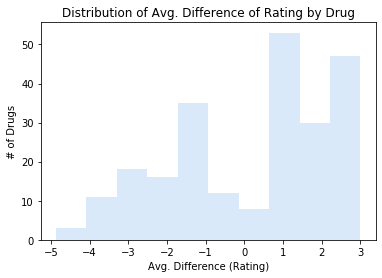

In [252]:
# plot distribution of average difference
#diff_avgs = [i[1] for i in diff_avg_drugs]

sns.distplot(diff_avg_drugs['diff_avg'], bins=10, kde=False)
plt.xlabel('Avg. Difference (Rating)')
plt.ylabel('# of Drugs')
plt.title('Distribution of Avg. Difference of Rating by Drug')
plt.show()

## Rating by Condition

To help minimize outliers and conditions with a small sample size I filtered out conditions that appeared less than 50 times in the data.

In [178]:
# only include conditions that have at least 50 reviews
condition_names = data.condition.unique()
condition_counts = np.array([(i, data.condition[data.condition == i].count()) for i in condition_names])
condition_names_50 = [i[0] for i in condition_counts if i[1] >= '50']

### T-Test for Statistically Significant Avg. Difference
Again, t-test was used to determine which conditions had a statistically significant effect on average difference of rating.

My null hypothesis was that there was no difference between the average rating with and without the chosen condition. My alternative hypothesis was that there was a difference between rating with and without the chosen condition.

I used an alpha (p-value) of 0.5 and ran the t-test on each condition that appeared at least 50 times in the data.

In [179]:
# set alpha for t-test
alpha = 0.05

In [180]:
# perform t-test on ratings with and without each drug
pvalue_conditions = [(i, ttest(data, 'condition', i)) for i in condition_names_50]

# only include drugs with p-values below alpha
sig_conditions = [(i[0], i[1]) for i in pvalue_conditions if float(i[1]) < alpha]

# sort
sig_conditions.sort(key=lambda x: x[1])

### Average Difference in Rating
Out of the conditions with a statistically significant average difference in rating, I determined which conditions had the largest average difference.

In [181]:
# make a list of sig_drugs
sig_conditions_list = [i[0] for i in sig_conditions]

# avgerage difference of mean rating for each drug
diff_avg_conditions = [(i, diff_avg(data, 'condition', i)) for i in sig_conditions_list]

# sort by average difference
diff_avg_conditions.sort(key=lambda x:x[1])

In [253]:
# view summary statistics about conditions with significant average difference
diff_avg_conditions = pd.DataFrame(diff_avg_conditions, columns=['condition', 'diff_avg'])
diff_avg_conditions.describe()

,diff_avg
count,75.000000
mean,0.558180
std,1.703163
min,-3.245748
25%,-0.777590
50%,0.877442
75%,1.691556
max,3.004583


In [254]:
# display 10 conditions with largest average increase
top_diff_avg_conditions = diff_avg_conditions.sort_values('diff_avg', ascending=False)[:10]
display('10 conditions with largest average increase in rating:', top_diff_avg_conditions)

'10 conditions with largest average increase in rating:'

,condition,diff_avg
74,Costochondritis,3.004583
73,Menopausal Disorders,3.004583
72,B12 Nutritional Deficiency,3.004564
71,von Willebrand's Disease,3.004545
70,Gingivitis,3.004526
69,NSAID-Induced Gastric Ulce,2.861682
68,Dumping Syndrome,2.837854
65,Biliary Cirrhosis,2.671181
64,Mucositis,2.671181
67,"Herpes Simplex, Mucocutaneous/Immunocompromise...",2.671181


In [257]:
# display 10 conditions with largest average decrease
bottom_diff_avg_conditions = diff_avg_conditions.sort_values('diff_avg', ascending=True)[:10]
display('10 conditions with largest average decrease in rating:', bottom_diff_avg_conditions)

'10 conditions with largest average decrease in rating:'

,condition,diff_avg
0,Bronchospasm Prophylaxis,-3.245748
1,Sore Throat,-3.106871
2,"Herpes Zoster, Prophylaxis",-2.995698
3,Macular Edema,-2.852853
4,Pancreatic Exocrine Dysfunction,-2.495710
5,"Deep Vein Thrombosis, Recurrent Event",-2.440167
6,Prostatitis,-2.436529
8,Pelvic Inflammatory Disease,-2.217933
7,Body Dysmorphic Disorde,-2.217933
9,Keratoconjunctivitis Sicca,-1.570189


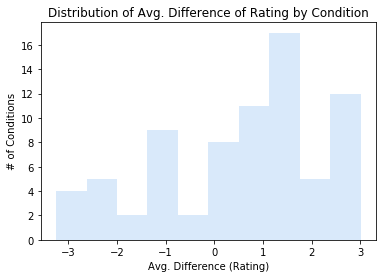

In [256]:
# plot distribution of average difference
diff_avgs = [i[1] for i in diff_avg_conditions]

sns.distplot(diff_avg_conditions['diff_avg'], bins=10, kde=False)
plt.xlabel('Avg. Difference (Rating)')
plt.ylabel('# of Conditions')
plt.title('Distribution of Avg. Difference of Rating by Condition')
plt.show()

## Rating by Word

In [23]:
# create array of terms
terms = term_matrix.columns

### T-Test for Statistically Significant Average Difference
I wanted to first evaluate which words had a statistically significant difference on average rating.

My null hypotheses was that the difference between average ratings with and without the chosen word would be equal to zero. My alternative hypothesis was that the difference between average ratings with and without the chosen word would not be equal to zero.

An alpha (p-value) of 0.05 was chosen to determine significance.

In [24]:
# set alpha
alpha = 0.05

# define function for t-test
def ttest_term(data, term):
    ''' Function to run a t-test on ratings with and without each term and return p-value.'''
    has = data[data[term] > 0].rating
    has_not = data[data[term] == 0].rating
    t, p = stats.ttest_ind(has, has_not)
    return p

In [25]:
# perform t-test on ratings with and without each term
pvalue_terms = [(i, ttest_term(term_matrix, i)) for i in terms]

# only include drugs with p-values below alpha
sig_terms = [(i[0], i[1]) for i in pvalue_terms if float(i[1]) < alpha]

# sort
sig_terms.sort(key=lambda x: x[1])

### Average Difference

After determining which words had a significant difference on average rating, I wanted to determine words with the largest significant difference on average rating.

In [131]:
def diff_avg_word(data, word):
    """Function to return difference of mean ratings with and without each word."""
    has = np.mean(data[data[word] != 0].rating)
    has_not = np.mean(data[data[word] == 0].rating)
    diff = has - has_not
    return diff

In [138]:
# extract terms with significant difference from sig_terms
sig_term_list = [i[0] for i in sig_terms]

# calculate significant average difference of mean rating for each term
diff_avg_terms = [(i, diff_avg_word(term_matrix, i)) for i in sig_term_list]

# sort by average difference
diff_avg_terms.sort(key=lambda x:x[1])

In [258]:
# view summary statistics about conditions with significant average difference
diff_avg_terms = pd.DataFrame(diff_avg_terms, columns=['word', 'diff_avg'])
diff_avg_terms.describe()

,diff_avg
count,342.000000
mean,0.039175
std,0.798224
min,-2.147107
25%,-0.634753
50%,0.132927
75%,0.754392
max,1.763794


In [260]:
# display 10 words with largest significant average increase
top_diff_avg_terms = diff_avg_terms.sort_values('diff_avg', ascending=False)[:10]
display('10 words with largest average increase in rating:', top_diff_avg_terms)

'10 words with largest average increase in rating:'

,word,diff_avg
341,radio,1.763794
340,coworker,1.534592
339,levoxyl,1.409158
338,aspergers,1.399081
337,laminectomy,1.387501
336,loaded,1.371777
335,managable,1.368772
334,epileptic,1.366272
333,simplest,1.360792
332,natazia,1.332585


In [261]:
# display 10 words with largest significant average decrease
bottom_diff_avg_terms = diff_avg_terms.sort_values('diff_avg', ascending=True)[:10]
display('10 words with largest average decrease in rating:', bottom_diff_avg_terms)

'10 words with largest average decrease in rating:'

,word,diff_avg
0,moist,-2.147107
1,consists,-1.495447
2,separation,-1.481187
3,tumour,-1.432935
4,wire,-1.432935
5,meanwhile,-1.427359
6,prednisolone,-1.401679
7,manufactured,-1.395454
8,fasciitis,-1.389374
9,compressed,-1.337571


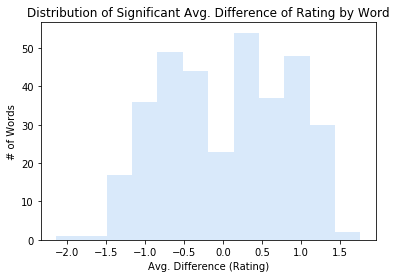

In [263]:
# plot distribution of significant average differences
sns.distplot(diff_avg_terms['diff_avg'], bins=12, kde=False)
plt.xlabel('Avg. Difference (Rating)')
plt.ylabel('# of Words')
plt.title('Distribution of Significant Avg. Difference of Rating by Word')
plt.show()